# Importer les bibliothèques nécessaires

In [2]:
import importlib

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import XGate, ZGate

import matplotlib.pyplot as plt
import numpy as np

import os, sys
sys.path.append(os.getcwd())

In [ ]:
# This for Google Colab, so that we can import the files from the repository
#!git clone https://github.com/algolab-quantique/IMACA-CMAI-Grover.git

#sys.path.insert(0,'/content/IMACA-CMAI-Grover')

In [3]:
# Import the utils functions from the repository
from utils import get_disjunction_control_state, get_disjunction_qubits

# Les sept clauses du problème de Pincus

Une clause de la forme

$
    (x_0 \lor x_2 \lor \neg x_3)
$

est écrite : 
```
clause = {'x0' : True, 'x2' : True, 'x3' : False}
````

Rappel : 

* x0 = Peureux
* x1 = Heureux
* x2 = Malade
* x3 = Bruyant


In [4]:
clauses = []

# Si un habitant est en santé et courageux, il est aussi bruyant. 
# (x2 ⌵ x0 ⌵ x3)  
clauses.append({'x2' : True, 'x0' : True, 'x3' : True})

# Si un habitant est peureux et discret, il est aussi heureux.
# (¬x0 ⌵ x3 ⌵ x1)  
clauses.append({'x1' : True, 'x0' : False, 'x3' : True})

# Si un habitant est en santé et bruyant, il est aussi heureux.
# (x2 ⌵ ¬x3 ⌵ x1)  
clauses.append({'x2' : True, 'x1' : True, 'x3' : False})

# Si un habitant est en heureux et discret, il est aussi en santé.
# (¬x1 ⌵ x3 ⌵ ¬x2)  
clauses.append({'x2' : False, 'x1' : False, 'x3' : True})

# Si un habitant est en peureux et en santé, il est aussi triste.
# (¬x0 ⌵ x2 ⌵ ¬x1)  
clauses.append({'x2' : True, 'x0' : False, 'x1' : False})

# Si un habitant est en triste et malade, il est aussi peureux.
# (x1 ⌵ ¬x2 ⌵ x0)  
clauses.append({'x2' : False, 'x0' : True, 'x1' : True})

# Si un habitant est en peureux et bruyant, il est aussi en santé.
# (¬x0 ⌵ ¬x3 ⌵ ¬x2)  
clauses.append({'x2' : False, 'x0' : False, 'x3' : False})

# Données connues du problème

In [6]:
# x0 : peureux, x1 : heureux, x2 : malade, x3 : bruyant
nb_variables = 4
# 7 clauses
nb_clauses = len(clauses)
print(nb_clauses)

7


# Création d'une fonction pour transformer la disjonction en un circuit

Nous allons définir une fonction qui prend en entrée une disjonction et qui la transforme en circuit quantique. 

Par exemple, la formule : 

$
    (x_0 \lor x_1 \lor \neg x_2)
$

serait transformée en la série de portes suivantes : 

<img src="images/disj_circuit.png" alt= “” width="15%" height="15%">

Chaque disjonction est transformée en un circuit contenant autant de qubits qu'il y a de variables dans la formule, en
plus d'un qubit ancillaire associé à la clause en question. Le circuit est ensuite converti en une porte qui peut être
ajoutée à un circuit (notamment à l'oracle), en spécifiant les bons qubits. 

In [7]:
# Transformer une disjonction en une porte
def logical_disjunction_to_gate(disj_clause):
    # Nombre de variables dans la clause
    nb_disj_variables = len(disj_clause)
    
    # Nombre de qubits dans la porte de disjonction (nb_variables + 1 qubit ancillaire)
    nb_qubits = nb_disj_variables + 1
    disj_qc = QuantumCircuit(nb_qubits)
    qubits = disj_qc.qubits
    
    # Obtenir le bon état de controle pour la porte multi-controle X
    ctrl_state = get_disjunction_control_state(disj_clause)
    
    # Créer une porte multi-controle X avec le bon nombre de qubits
    mc_xgate = XGate().control(num_ctrl_qubits=nb_disj_variables, ctrl_state = ctrl_state)
    disj_qc.append(mc_xgate, qubits)
    
    # Ajouter une porte X au qubit à la position -1 (dernière), le qubit ancillaire
    disj_qc.x(qubits[-1])
    
    # Transformer le circuit de disjonction en une porte avec un nom, mcx
    disj_gate = disj_qc.to_gate(label='mcx')
    return disj_gate

Voyons comment on peut utiliser cette fonction.

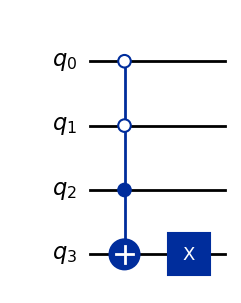

In [8]:
clause_test = {'x0' : True, 'x1' : True, 'x2' : False}

test_qc = QuantumCircuit(4)
disj_gate = logical_disjunction_to_gate(clause_test)
test_qc.append(disj_gate,range(4))
test_qc.decompose().draw('mpl')

# Construire l'oracle

In [9]:
# Créer des registres quantiques pour les variables et les clauses
var_qubits = QuantumRegister(nb_variables, name='x')
clause_qubits = QuantumRegister(nb_clauses, name='c')

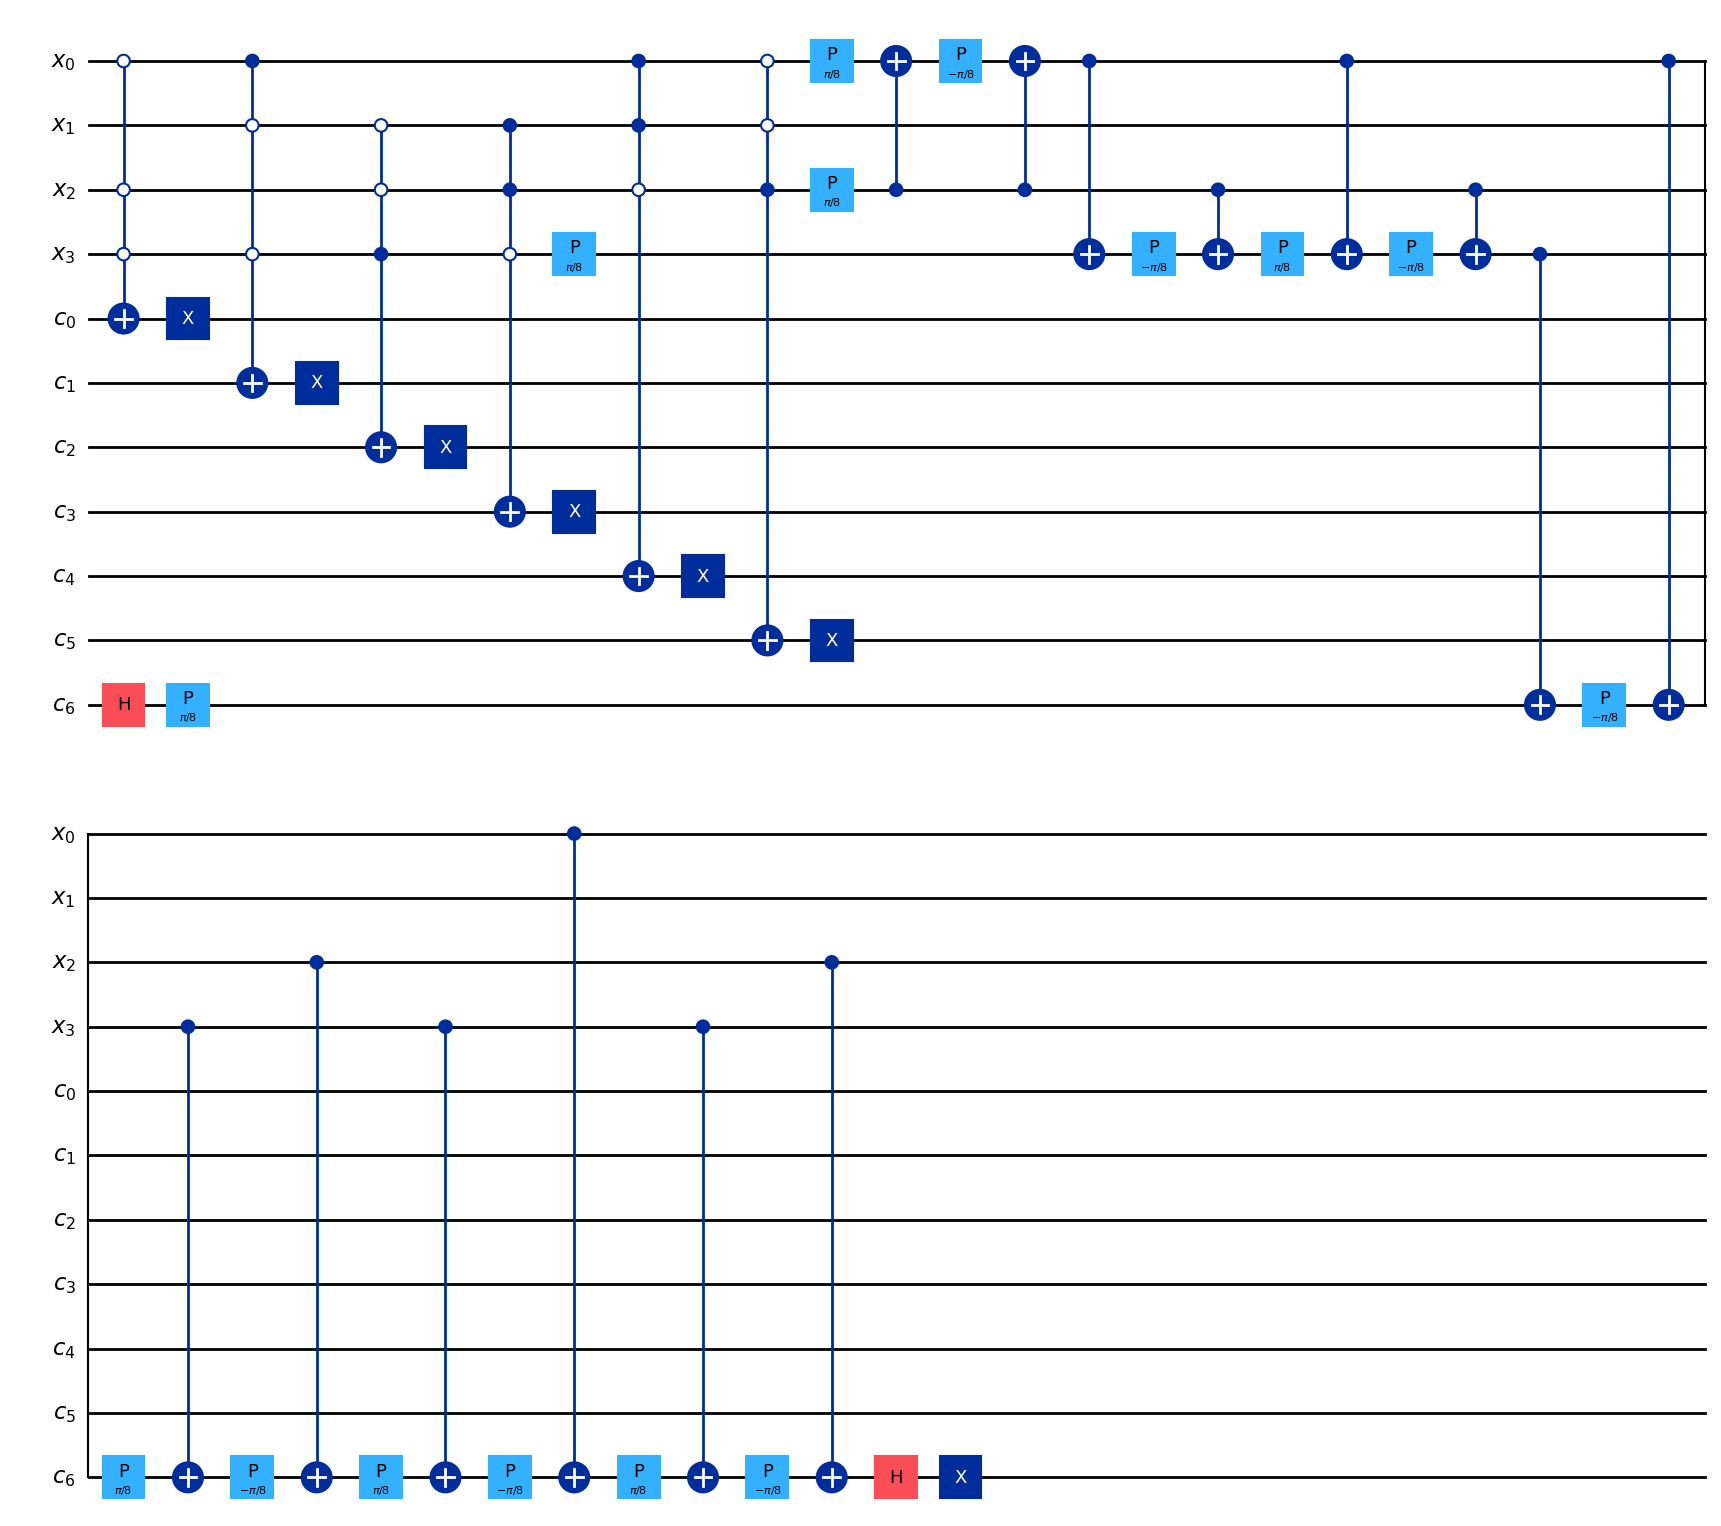

In [10]:
# Construire le circuit de clauses
clauses_circuit = QuantumCircuit(var_qubits, clause_qubits)

# Ajouter chaque clause de disjonction comme une porte : 
for i in range(nb_clauses):
    # Convertir la disjonction en porte
    gate = logical_disjunction_to_gate(clauses[i])
    # Sélectionner les qubits associés à la clause
    c_qubits = get_disjunction_qubits(clauses[i], clause_qubits[i], var_qubits)
    # Ajouter la porte au circuit de clauses
    clauses_circuit.append(gate, c_qubits)

# Afficher le circuit : 
clauses_circuit.decompose(gates_to_decompose=['mcx'], reps=2).draw(output='mpl')

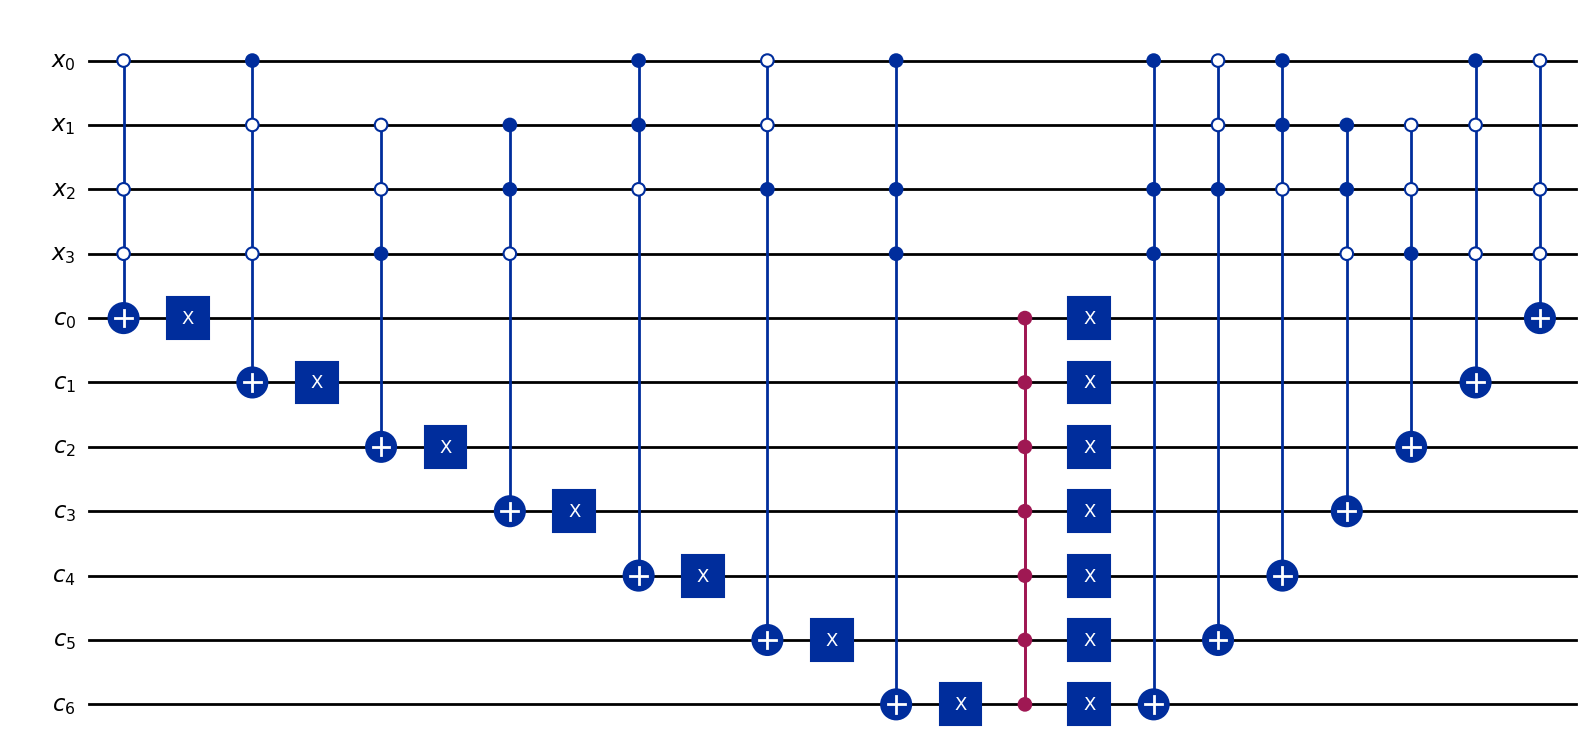

In [11]:
# Construire le circuit de l'oracle
oracle_circuit = QuantumCircuit(var_qubits, clause_qubits)

# Ajouter le circuit de clauses 
# --- la transformation vers une porte n'est utile qu'à des fins d'affichage plus tard ---
oracle_circuit.append(clauses_circuit.to_gate(label='clauses_circuit'), clauses_circuit.qubits)

# Ajouter la porte multi-controle Z
mc_z_gate = ZGate().control(nb_clauses - 1)
oracle_circuit.append(mc_z_gate, clause_qubits)

# Ajouter l'inverse du circuit de clauses
oracle_circuit.append(clauses_circuit.reverse_ops().to_gate(label='clauses_circuit'), oracle_circuit.qubits)

# Afficher le circuit
oracle_circuit.decompose(gates_to_decompose=['clauses_circuit', 'mcx'], reps=2).draw(output='mpl')


# Construire le diffuseur

Complétez le circuit du diffuseur.

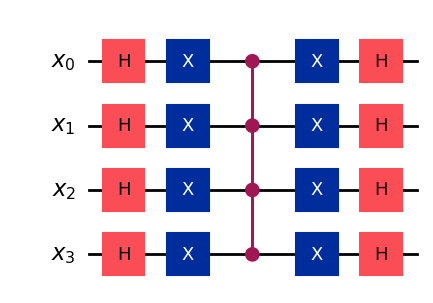

In [14]:
# Construire le circuit de diffuseur
diffuser_circuit = QuantumCircuit(var_qubits)

# Ajouter des portes H et X pour chaque qubit du diffuseur
### 4 portes H pour les variables
diffuser_circuit.h([0,1,2,3])
### 4 portes X pour les variables
diffuser_circuit.x([0,1,2,3])
# Ajouter une multi-controle Z  
mc_z_gate = ZGate().control(nb_variables - 1)
diffuser_circuit.append(mc_z_gate, var_qubits)

# Ajouter des portes X et H pour chaque qubit du diffuseur
### 4 portes X pour les variables
diffuser_circuit.x([0,1,2,3])
### 4 portes H pour les variables
diffuser_circuit.h([0,1,2,3])

# Afficher le circuit
diffuser_circuit.draw(output='mpl')

# Assembler le circuit de Grover

Complétez le circuit de Grover.

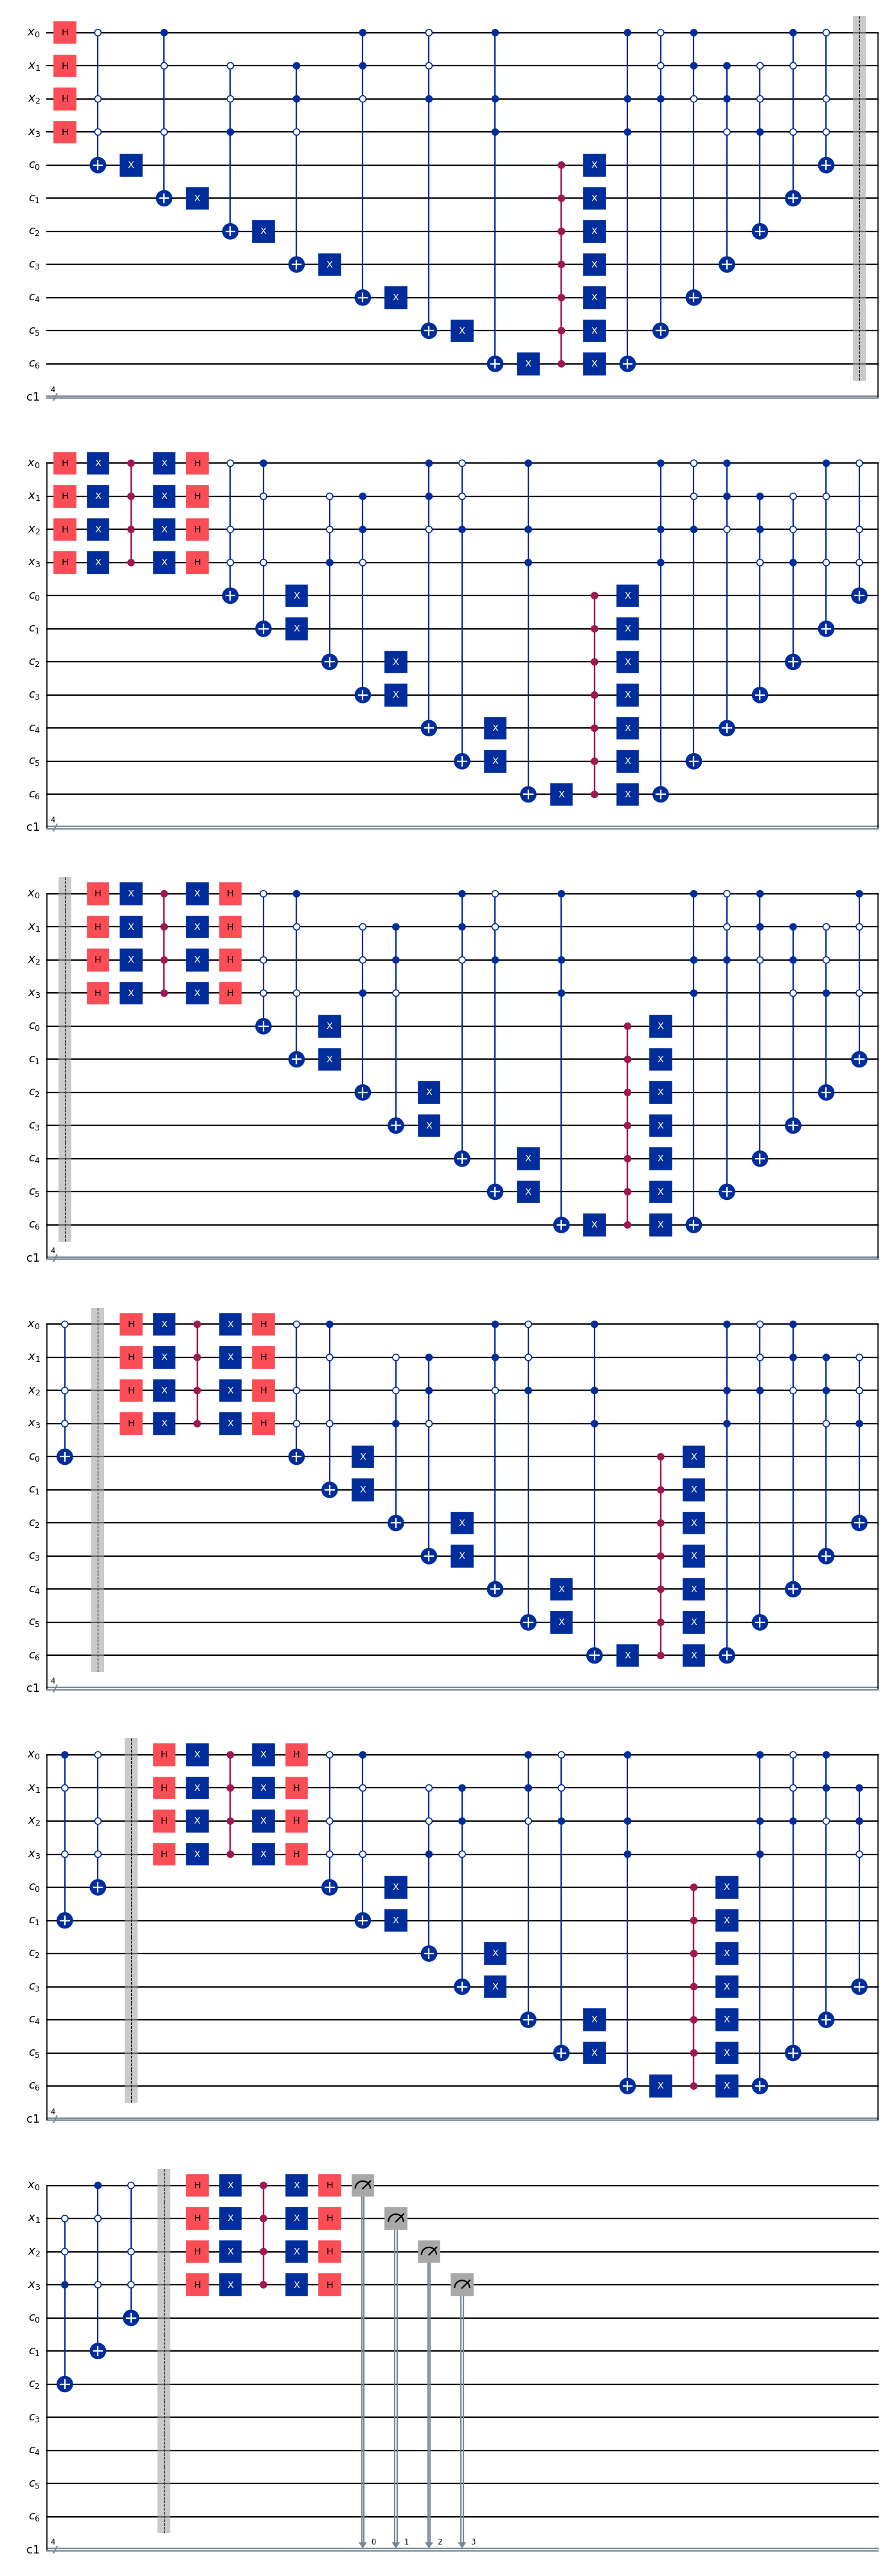

In [19]:
# Construire le circuit de Grover
c_bits = ClassicalRegister(nb_variables)
grover_circuit = QuantumCircuit(var_qubits, clause_qubits, c_bits)

# Ajouter des portes H pour chaque variable
grover_circuit.h([0,1,2,3])

# Identifier le nombre d'iterations
nb_iterations = 5 # Jouez avec le nombre d'itérations pour en voir l'effet

# Ajouter autant d'oracles et de diffuseurs qu'il y a de nombre d'itérations
for it in range(nb_iterations):
    grover_circuit.append(oracle_circuit.to_gate(label='oracle'), grover_circuit.qubits)
    grover_circuit.barrier(grover_circuit.qubits)
    grover_circuit.append(diffuser_circuit.to_gate(label='diffusor'), grover_circuit.qubits[0:nb_variables])
    
# Ajouter les mesures pour l'evaluation du circuit
grover_circuit.measure(var_qubits, c_bits)

# Afficher le circuit
grover_circuit.decompose(gates_to_decompose=['oracle', 'clauses_circuit', 'diffusor', 'mcx'], reps=3).draw(output='mpl',
                                                                                                   scale=0.8)

# Mesure de la solution

In [20]:
from qiskit_aer import AerSimulator
from qiskit import transpile

# Prepaper une simulation pour rouler et mesurer la solution
def run_circuit(circ: QuantumCircuit) -> dict:
    """
    Run a quantum circuit on the AerSimulator and return the counts
    @param circ: QuantumCircuit to run
    @return: dictionary of measurement results and their counts
    """
    simulator = AerSimulator()
    circ = transpile(circ, simulator)
    result = simulator.run(circ, shots=1000).result()
    return result.get_counts(circ)

In [21]:

# Executer le circuit et obtenir le compte de solutions
counts = run_circuit(grover_circuit)

print(counts)

{'1001': 31, '0001': 40, '1010': 304, '1110': 259, '1000': 31, '0000': 34, '0110': 32, '1100': 32, '0101': 32, '1011': 25, '0010': 24, '0100': 30, '0011': 30, '0111': 33, '1111': 30, '1101': 33}


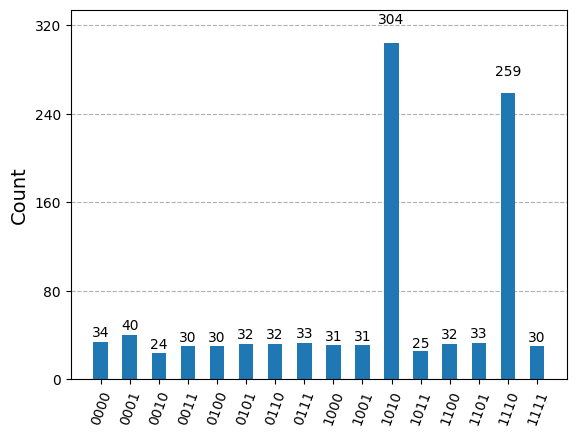

In [22]:
# Afficher l'histogramme de comptes
plot_histogram(counts)

Rappel : 

* x0 = Peureux
* x1 = Heureux
* x2 = Malade
* x3 = Bruyant

# Exercice : Planification optimale d’un voyage à Quanta avec l’algorithme de Grover

Considère ce nouveau problème de satisfiabilité : 

De retour de la planète Pincus, tu souhaites planifier un voyage de cinq jours à Quanta, un pays gigantesque. Comme le temps est limité, tu souhaites optimiser ton voyage de façon à visiter le plus d'endroits possibles. Tu demandes alors au sage de Quanta, qui connait très bien le pays, de t'aider dans ta planification. Il te donne les affirmations suivantes : 

1- Si tu arrives jusqu'au désert, tu ne peux pas aller voir la forêt.
    Désert → ¬Forêt

2- L'océan est un paysage à ne pas manquer, tu dois absolument y aller. 
    Océan 

3- Si tu visites le lac, tu ne peux pas te rendre à la capitale. 
    Lac → ¬Capitale

4- Si tu visites la capitale, tu ne peux pas aller voir l'océan. 
    Capitale → ¬Océan

5- Si tu vas voir le lac, il faut absolument que tu passes par la forêt : c'est just à côté! 
    Lac → Forêt

Utilises l'algorithme de Grover pour déterminer les solutions du problème, c'est à dire les combinaisons possibles d'endroits que tu vas visiter lors de ton voyage à Quanta. Quelle est la combinaison la plus grande d'endroits que tu iras voir? 


Indice : La formule logique du problème, sous forme normale conjonctive, est en annexe à la question, avec 
- d = désert
- c = capitale
- l = lac
- f = forêt 
- o = océan.

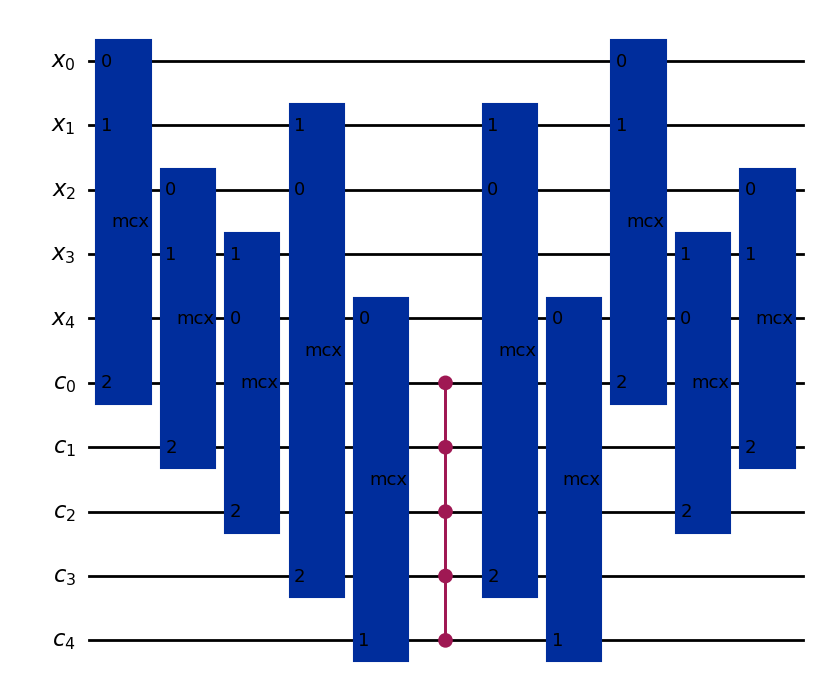

In [40]:
from qiskit import QuantumRegister, QuantumCircuit
from qiskit.circuit.library import ZGate
import utils
import importlib
importlib.reload(utils)

# Définition des clauses (forme CNF)
clauses_exo = []
clauses_exo.append({'x0': False, 'x1': False})
clauses_exo.append({'x2': False, 'x3': False})
clauses_exo.append({'x4': False, 'x3': False})
clauses_exo.append({'x2': False, 'x1': True})
clauses_exo.append({'x4': True})

# Paramètres
nb_variables = 5
nb_clauses = len(clauses_exo)

# Registres quantiques
var_qubits = QuantumRegister(nb_variables, name='x')
clause_qubits = QuantumRegister(nb_clauses, name='c')

# Circuit pour appliquer les clauses
clauses_circuit = QuantumCircuit(var_qubits, clause_qubits)

# Construction de chaque clause
for i in range(nb_clauses):
    gate = logical_disjunction_to_gate(clauses_exo[i])
    c_qubits = get_disjunction_qubits(clauses_exo[i], clause_qubits[i], var_qubits)
    clauses_circuit.append(gate, c_qubits)

# Circuit final de l'oracle
oracle_circuit = QuantumCircuit(var_qubits, clause_qubits)

# 1. Appliquer les clauses (dans une sous-porte)
oracle_circuit.append(clauses_circuit.to_gate(label='clauses_circuit'), clauses_circuit.qubits)

# 2. Appliquer la conjonction via Z multi-contrôlée
mc_z_gate = ZGate().control(nb_clauses - 1)
oracle_circuit.append(mc_z_gate, clause_qubits[:-1] + [clause_qubits[-1]])

# 3. Désappliquer les clauses (uncomputation)
oracle_circuit.append(clauses_circuit.reverse_ops().to_gate(label='clauses_circuit'), clauses_circuit.qubits)

# 4. Afficher le circuit décomposé


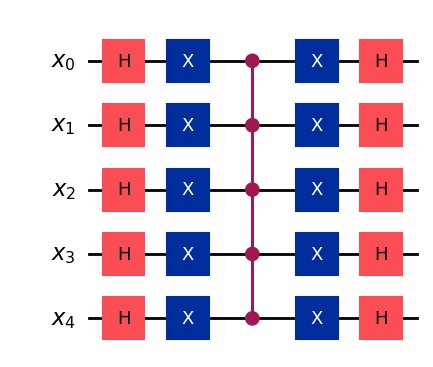

In [42]:
# Construire le circuit de diffuseur
diffuser_circuit = QuantumCircuit(var_qubits)

# Ajouter des portes H et X pour chaque qubit du diffuseur
### 4 portes H pour les variables
diffuser_circuit.h([0,1,2,3,4])
### 4 portes X pour les variables
diffuser_circuit.x([0,1,2,3,4])
# Ajouter une multi-controle Z
mc_z_gate = ZGate().control(nb_variables - 1)
diffuser_circuit.append(mc_z_gate, var_qubits)

# Ajouter des portes X et H pour chaque qubit du diffuseur
### 4 portes X pour les variables
diffuser_circuit.x([0,1,2,3,4])
### 4 portes H pour les variables
diffuser_circuit.h([0,1,2,3,4])

# Afficher le circuit
diffuser_circuit.draw(output='mpl')

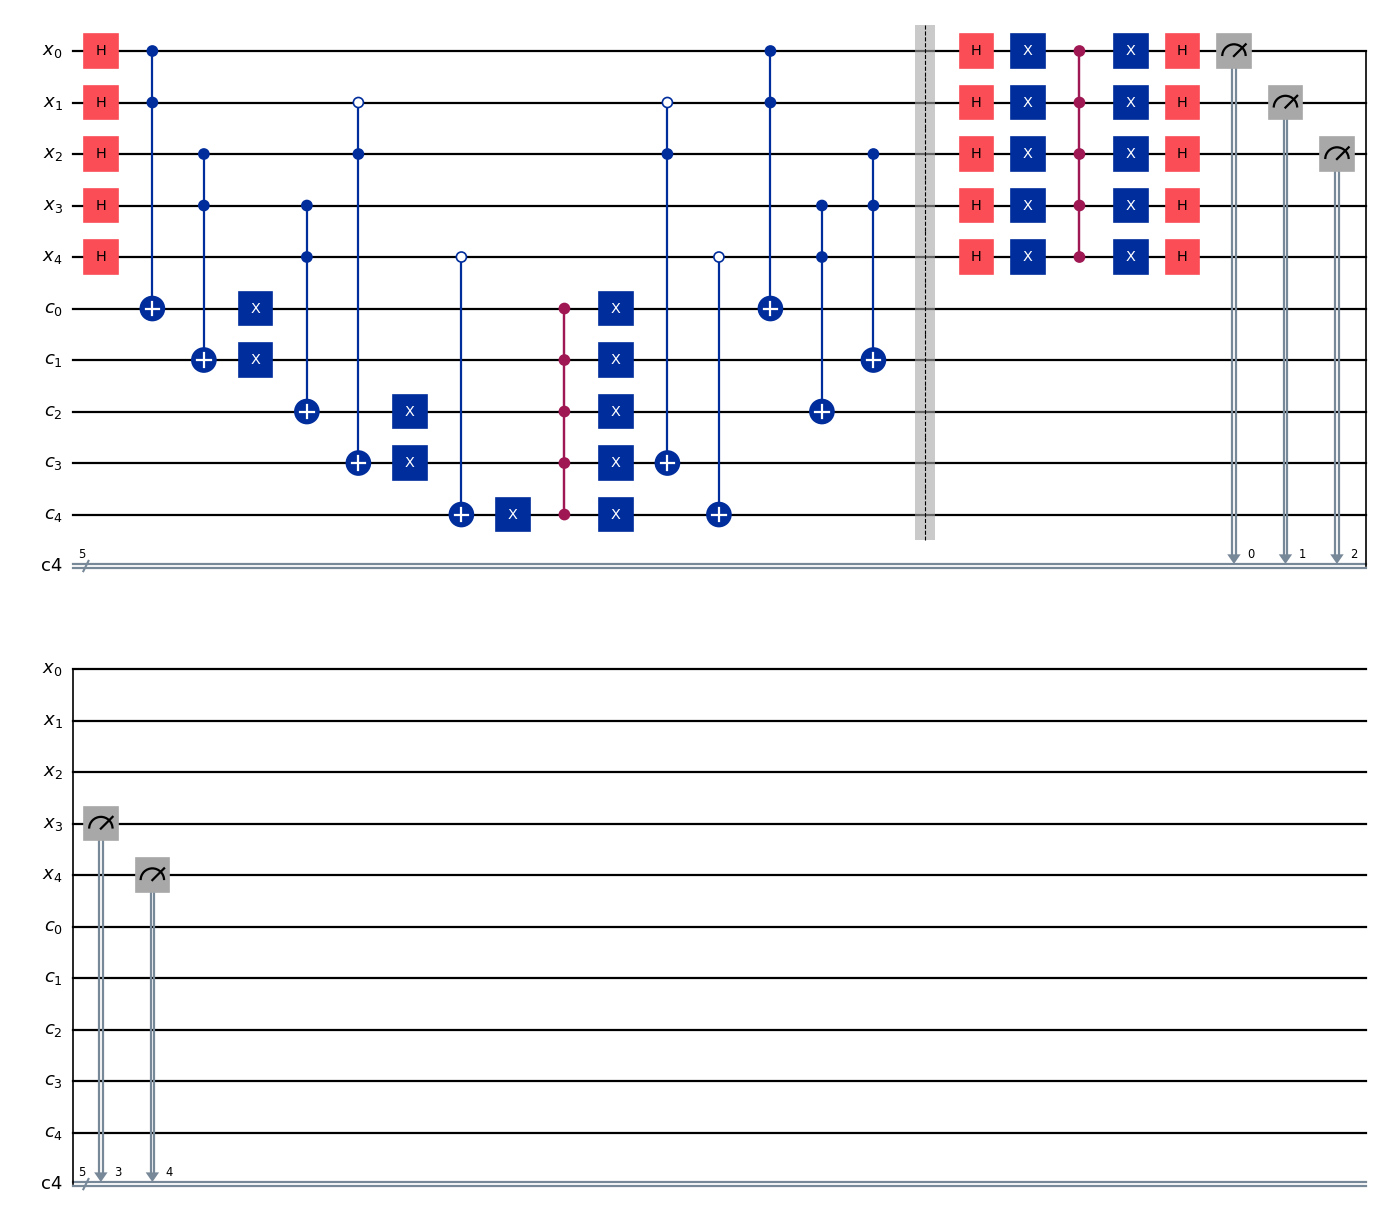

In [43]:
c_bits = ClassicalRegister(5)
grover_circuit = QuantumCircuit(var_qubits, clause_qubits, c_bits)
# Ajouter des portes H pour chaque variable
grover_circuit.h([0,1,2,3,4])

# Identifier le nombre d'iterations
nb_iterations = 1 # Jouez avec le nombre d'itérations pour en voir l'effet

# Ajouter autant d'oracles et de diffuseurs qu'il y a de nombre d'itérations
for it in range(nb_iterations):
    grover_circuit.append(oracle_circuit.to_gate(label='oracle'), grover_circuit.qubits)
    grover_circuit.barrier(grover_circuit.qubits)
    grover_circuit.append(diffuser_circuit.to_gate(label='diffusor'), grover_circuit.qubits[0:nb_variables])

# Ajouter les mesures pour l'evaluation du circuit
grover_circuit.measure(var_qubits, c_bits)

# Afficher le circuit
grover_circuit.decompose(gates_to_decompose=['oracle', 'clauses_circuit', 'diffusor', 'mcx'], reps=3).draw(output='mpl',
                                                                                                   scale=0.8)

In [44]:
from qiskit_aer import AerSimulator
from qiskit import transpile

# Prepaper une simulation pour rouler et mesurer la solution
def run_circuit(circ: QuantumCircuit) -> dict:
    """
    Run a quantum circuit on the AerSimulator and return the counts
    @param circ: QuantumCircuit to run
    @return: dictionary of measurement results and their counts
    """
    simulator = AerSimulator()
    circ = transpile(circ, simulator)
    result = simulator.run(circ, shots=1000).result()
    return result.get_counts(circ)

In [45]:

# Executer le circuit et obtenir le compte de solutions
counts = run_circuit(grover_circuit)

print(counts)

{'10110': 214, '10010': 192, '11010': 7, '10001': 216, '10011': 8, '11100': 10, '11000': 6, '10000': 193, '11110': 10, '10111': 10, '01001': 12, '00011': 10, '11011': 4, '11111': 10, '11101': 4, '01101': 8, '01100': 6, '00001': 4, '01011': 4, '00100': 5, '00000': 4, '10101': 8, '00110': 4, '00111': 7, '00101': 7, '01000': 7, '10100': 7, '01110': 8, '00010': 5, '11001': 5, '01111': 5}


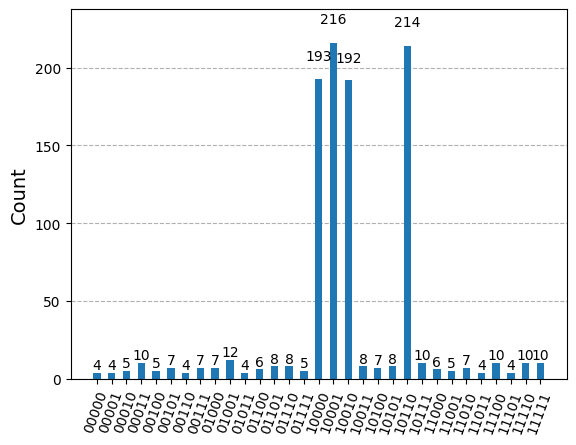

In [46]:
# Afficher l'histogramme de comptes
plot_histogram(counts)
